# Exercise 3.14
Take the position of your home in Pisa (point A) and the position of theDepartment of Computer Science (point B). Compute the shortest path $p(A,B)$ between A and B. Now select the roads $e_1, e_2$ that are the closest to the points $P_1$ and $P_2$, which are at a (earth) distance d on a straight line R that intersects the segment S that connects A and B at its middle and that is perpendicular to S.
* Visualize the three paths
* Compute the difference between the two new path and path $p(A, B)$, in terms of geographic distance and number of roads
* Submit a (well documented) notebook

## Importing the Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import math

import skmob
from skmob.utils.plot import plot_gdf
import folium
import random

import urllib.request
import requests

import osmnx as ox
from shapely.geometry import *

## Some useful Functions

In [2]:
def flip_xy(point): #writing a simple function to avoid putting always the inverse coordinates of a point in folium
    return point.y, point.x

def get_centroid(geometry): #it's because of the constant warning, so that I get a centroid without it
    return geometry.to_crs('+proj=cea').centroid.to_crs('epsg:4326')

## Importing the data

In [3]:
# Importing the necessary data (I declared them so that I can call all shapes with pattern: shp[0])
home = [Point((10.425288, 43.720667))]
cs_dep_poly = ox.geocode_to_gdf('Polo Fibonacci, Via Filippo Buonarroti, Pisa', which_result=1)['geometry']
cs_dep_centroid = get_centroid(cs_dep_poly)

## Drawing a Line and testing Parallel Lines

In [ ]:
# Drawing a straight line between home and the computer science departement
S = LineString((home[0], cs_dep_centroid[0]))
S_c = S.centroid
GeometryCollection((S, S_c))

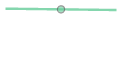

In [ ]:
#testing parallel lines
GeometryCollection((S, S.parallel_offset(S.length / 2, 'right'), S.parallel_offset(S.length / 6, 'left')))


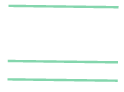

## Computing Earth Distance between Home and the CS dep

In [6]:
#I already written this in a previous exercise (2.1 if I'm not wrong)

from math import cos, sin, asin, sqrt, pi, tan

def to_radians(*args): #I needed radians to work with trigonometry
    for raw in args:
        yield raw*(pi/180) #I made it a generator out of convenience

def haversine_formula(P, Q):
    latP, lonP = P
    latQ, lonQ = Q
    #converting the latitude and longitudes to radians
    latP, lonP, latQ, lonQ = tuple(to_radians(latP, lonP, latQ, lonQ))
    #print(latP, lonP, latQ, lonQ)

    earth_radius = 6371 #km, from wikipedia

    Dlat = latQ - latP
    Dlon = lonQ - lonP

    #I copied and translated the formula to python
    to_sqrt = sin(Dlat/2)**2 + cos(latP)*cos(latQ)*sin(Dlon/2)**2
    d = 2*earth_radius*asin(sqrt(to_sqrt))

    return  d

In [7]:
home_cs_dist = haversine_formula(flip_xy(home[0]), flip_xy(cs_dep_centroid[0]))
print(f'Home is {home_cs_dist:.2f} km away from the Computer Science Departement')

Home is 1.38 km away from the Computer Science Departement


## Making a perpendicular line R
Making a perpendicular line R of half the length of the distance between home and the cs dep

### Computing the length of half of the line

In [8]:
# Half of the distance because half of the line will be on top and half on bottom and...
#... because in this case being a almost horizontal line the max absolute latitude (90°) is half of longitude (180°)
# I added also 500 m to avoid overlapping path (only visualization purposes)

length = math.radians((home_cs_dist + 0.5) / 2) / 2

### Difficult version

In [9]:
angle = math.pi / 2

P1 = Point(S_c.x + length * math.cos(angle),
           S_c.y + length * math.sin(angle))
P2 = Point(S_c.x - length * math.cos(angle),
           S_c.y - length * math.sin(angle))

R = LineString([P1, P2])

In [10]:
P1_P2_dist = haversine_formula(flip_xy(P1), flip_xy(P2))
print(f'P1 is {P1_P2_dist:.2f} km away from the P2') #it should be around the same distance as home and cs dep + 500m

P1 is 1.82 km away from the P2


In [ ]:
#visualizing if they are crossing perpendicularly as predicted
GeometryCollection((R, S))

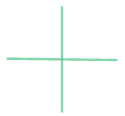

### Easy version
I checked, both ways gives the same Points as result

In [ ]:
#EASIEST WAY FOR ME
#Reasoning: creating a paralell line distant half-half the euclidean length of the original line, then taking the centroid to get a position on the parallel line
P1 = S.parallel_offset(length, 'left').centroid 
P2 = S.parallel_offset(length, 'right').centroid
R = LineString([P1, P2])
R_c = R.centroid
GeometryCollection((R, R_c))

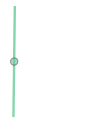

In [ ]:
#visualizing if they are crossing perpendicularly as predicted
GeometryCollection((R, S))

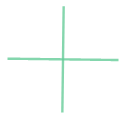

The two new points earth distance d is:

In [14]:
P1_P2_dist = haversine_formula(flip_xy(P1), flip_xy(P2))
print(f'P1 is {P1_P2_dist:.2f} km away from the P2') #it should be around the same distance as home and cs dep + 500m

P1 is 1.82 km away from the P2


In [15]:
P1_P2_dist / home_cs_dist # it should be greater than 1 (slightly greater numerator)

1.3229714605284113

## Downloading and visualizing the road network graph

In [16]:
# Downloading road network from centroid of the line between home and the cs_dep (at the center of my map)
G = ox.graph_from_point(flip_xy(S_c), dist=1500, network_type="all")

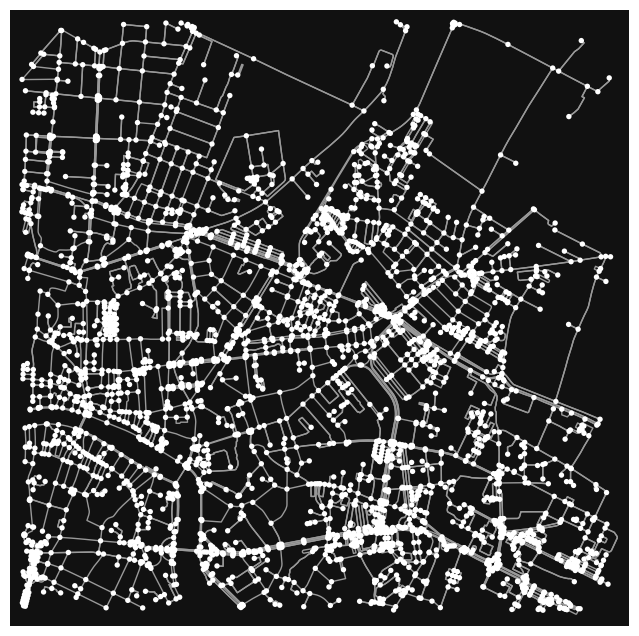

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [17]:
# Visualizing the road network
ox.plot_graph(G)

In [18]:
#storing the location of the nodes by the osmid
nodes = ox.graph_to_gdfs(G, edges=False)[['x', 'y']]
nodes.head()

,x,y
osmid,,
31680788,10.427598,43.709550
31770704,10.424695,43.710665
31770712,10.410429,43.710019
31770719,10.407815,43.711265
31770722,10.407784,43.713067


## Computing the three shortest routes:
With two routes passing through $e_1$ and $e_2$

In [19]:
# I wrote this to get the coordinates of a point in a node
def get_point_from_node(node, nodes):
    return Point(nodes.loc[node].values)

# I wrote this to count distinct roads in a forward trajectory 
# I supposed there wouldn't be a come back to the same road once left in a shortest path

def distinct_roads(route):
    distinct_roads = set() # I will add the name of the road so that only distinct road names will be here
    
    for node in route:
        info_node = dict(G[node])
        parent_node = list(info_node.keys())[0]
        try: # if it's a road it will have a name
            road_name = info_node[parent_node][0]['name']
            distinct_roads.add(road_name)
        except: # example a roundabout doesn't have a name but it has a node
            pass
    return distinct_roads

In [20]:
# computing nearest origin and destination nodes
orig_node = ox.distance.nearest_nodes(G, X=home[0].x, Y=home[0].y)
dest_node = ox.distance.nearest_nodes(G, X=cs_dep_centroid[0].x, Y=cs_dep_centroid[0].y)

# computing the shortest route between them by travel time
route_1 = ox.shortest_path(G, orig_node, dest_node, weight="length")

length_r1 = sum(ox.utils_graph.get_route_edge_attributes(G, route_1, "length"))

In [21]:
# computing nearest origin and destination nodes
orig_node = ox.distance.nearest_nodes(G, X=home[0].x, Y=home[0].y)
middle_node = ox.distance.nearest_nodes(G, X=P1.x, Y=P1.y)
dest_node = ox.distance.nearest_nodes(G, X=cs_dep_centroid[0].x, Y=cs_dep_centroid[0].y)

# computing the shortest route between them by travel time
route_2a = ox.shortest_path(G, orig_node, middle_node, weight="length")
route_2b = ox.shortest_path(G, middle_node, dest_node, weight="length")

# the routes are list of nodes so I can concatenate them easily
route_2 = route_2a + route_2b[1:] #I met an error because the last node of the route a is the same as the first of route b

length_r2 = sum(ox.utils_graph.get_route_edge_attributes(G, route_2, "length"))

In [22]:
# point at the middle of the road nearest to P1
e1_osm = get_point_from_node(middle_node, nodes)

In [23]:
# computing nearest origin and destination nodes
orig_node = ox.distance.nearest_nodes(G, X=home[0].x, Y=home[0].y)
middle_node = ox.distance.nearest_nodes(G, X=P2.x, Y=P2.y)
dest_node = ox.distance.nearest_nodes(G, X=cs_dep_centroid[0].x, Y=cs_dep_centroid[0].y)

# computing the shortest route between them by travel time
route_3a = ox.shortest_path(G, orig_node, middle_node, weight="length")
route_3b = ox.shortest_path(G, middle_node, dest_node, weight="length")

# the routes are list of nodes so I can concatenate them easily
route_3 = route_3a + route_3b[1:] #I met an error because the last node of the route a is the same as the first of route b

length_r3 = sum(ox.utils_graph.get_route_edge_attributes(G, route_3, "length"))

In [24]:
# point at the middle of the road nearest to P2
e2_osm = get_point_from_node(middle_node, nodes)

## Plotting the result

In [ ]:
map_f = folium.Map(flip_xy(S_c), zoom_start=15)

# Adding the Polygon of the CS departement
folium.GeoJson(cs_dep_poly).add_to(map_f)

# Add the Four Points as Markers
folium.Marker(flip_xy(home[0]), popup='Home',
              icon=folium.Icon(color='green')).add_to(map_f)
folium.Marker(flip_xy(cs_dep_centroid[0]), popup='Computer Science Departement',
              icon=folium.Icon(color='red')).add_to(map_f)
folium.Marker(flip_xy(e1_osm), popup='e1',
              icon=folium.Icon(color='blue')).add_to(map_f)
folium.Marker(flip_xy(e2_osm), popup='e2',
              icon=folium.Icon(color='blue')).add_to(map_f)

# Adding the two perpendicular lines
folium.GeoJson(S, style_function=lambda x: {'color':'black'}).add_to(map_f)
folium.GeoJson(R, style_function=lambda x: {'color':'black'}).add_to(map_f)

# Adding the routes with different colors
ox.plot_route_folium(G, route_1, route_map=map_f)
ox.plot_route_folium(G, route_2, route_map=map_f, color='#ff0000')
ox.plot_route_folium(G, route_3, route_map=map_f, color='#008000')

# Plot everthing
map_f

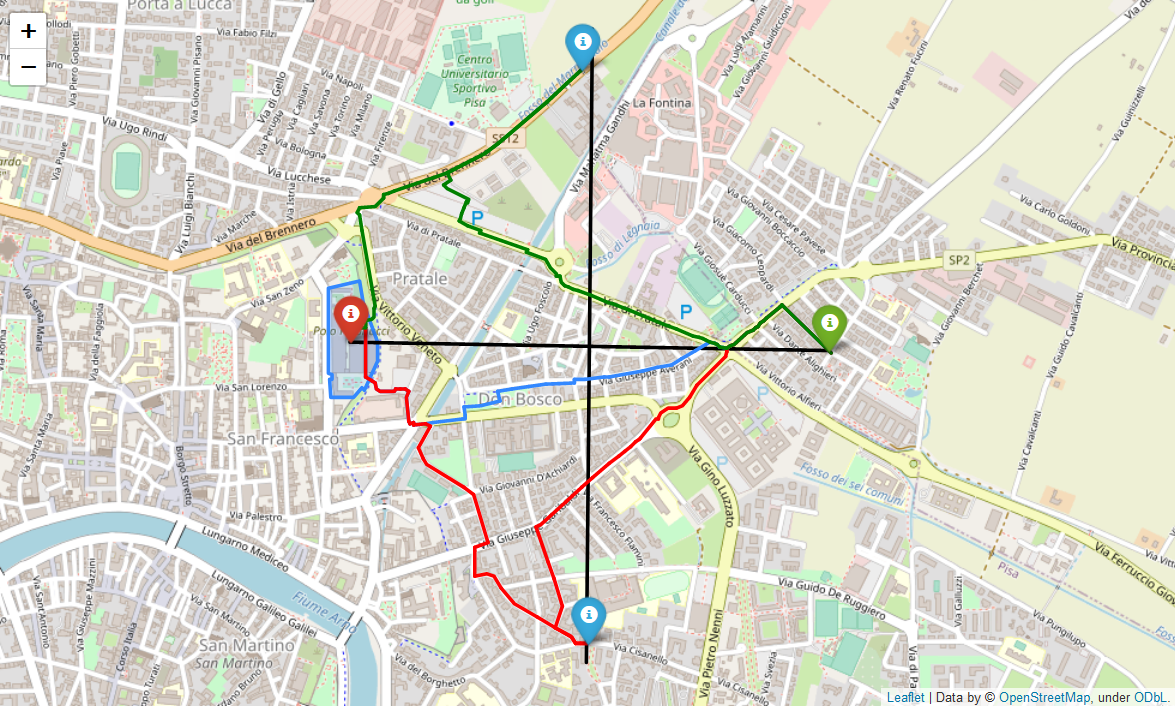

## Computing the Geographic Distance and the n° of Roads

In [26]:
# In the second column I just rounded the length of the road in meters I stored
# In the third column I got the distinct roads names for each route and compute the length of the set
pd.DataFrame([['Direct Route', round(length_r1 / 1000,2), len(distinct_roads(route_1))], 
              ['Passing through e1', round(length_r2 / 1000, 2), len(distinct_roads(route_2))], 
              ['Passing through e2', round(length_r3 / 1000, 2), len(distinct_roads(route_3))], 
              ], columns=['Route', 'Geographic distance (in km)', 'N° of roads'])

,Route,Geographic distance (in km),N° of roads
0,Direct Route,1.87,12
1,Passing through e1,3.05,19
2,Passing through e2,3.17,11
